# Libraries

In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Dataset

File: /kaggle/input/lens-finding/train_lenses/1.npy
Shape of the array: (3, 64, 64)
Data type of the array: float32
Min value in the array: 0.0
Max value in the array: 1.0
Sample data (first 5 elements): [0.20062892 0.21814357 0.17216861 0.16020806 0.20015164]

File: /kaggle/input/lens-finding/train_nonlenses/1.npy
Shape of the array: (3, 64, 64)
Data type of the array: float32
Min value in the array: 0.0
Max value in the array: 1.0
Sample data (first 5 elements): [0.1549283  0.08808557 0.10173576 0.17341936 0.14704707]



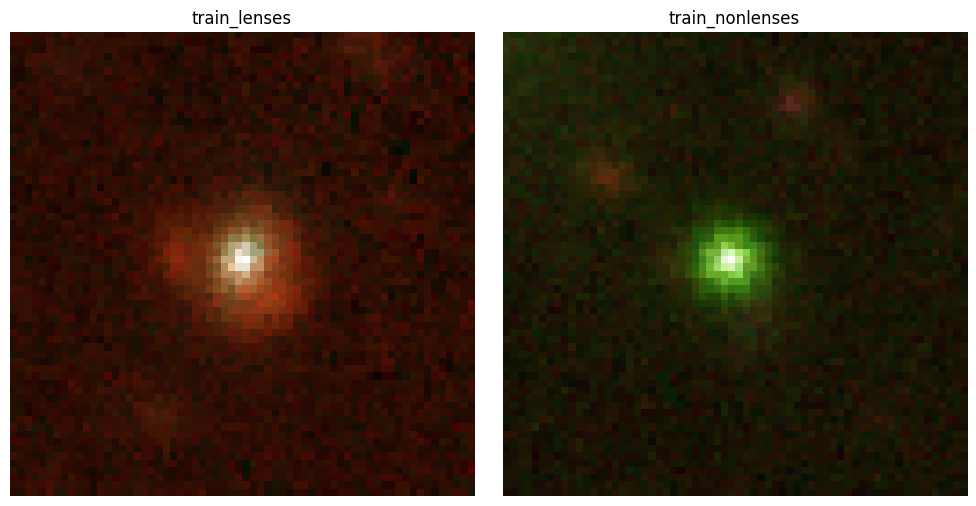

In [2]:
import numpy as np
import matplotlib.pyplot as plt

file_paths = [
    '/kaggle/input/lens-finding/train_lenses/1.npy',
    '/kaggle/input/lens-finding/train_nonlenses/1.npy'
]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for ax, file_path in zip(axes, file_paths):
    image_data = np.load(file_path)
    
    # Print the shape of the array
    print(f"File: {file_path}")
    print("Shape of the array:", image_data.shape)

    print("Data type of the array:", image_data.dtype)

    print("Min value in the array:", np.min(image_data))
    print("Max value in the array:", np.max(image_data))

    print("Sample data (first 5 elements):", image_data.flatten()[:5])
    print() 

    if image_data.ndim == 3 and image_data.shape[0] == 3:
        image_data = np.transpose(image_data, (1, 2, 0))
    
    ax.imshow(image_data)
    ax.axis('off')
    ax.set_title(file_path.split('/')[-2])

plt.tight_layout()
plt.show()

# Data loader

In [3]:
class LensDataset(Dataset):
    def __init__(self, lens_dir, nonlens_dir, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform  # Store the transform

        # Load lens images
        for fname in os.listdir(lens_dir):
            self.data.append(os.path.join(lens_dir, fname))
            self.labels.append(1)

        # Load non-lens images
        for fname in os.listdir(nonlens_dir):
            self.data.append(os.path.join(nonlens_dir, fname))
            self.labels.append(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load the image
        arr = np.load(self.data[idx])

        # Convert to a PIL Image if needed
        img = arr.transpose(1, 2, 0)  
        img = transforms.ToPILImage()(img)

        # Apply the transform if it exists
        if self.transform:
            img = self.transform(img)


        # Return the image and label
        return img, torch.tensor(self.labels[idx], dtype=torch.long)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = LensDataset(
    lens_dir="/kaggle/input/lens-finding/train_lenses",
    nonlens_dir="/kaggle/input/lens-finding/train_nonlenses",
    transform=transform
)

train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

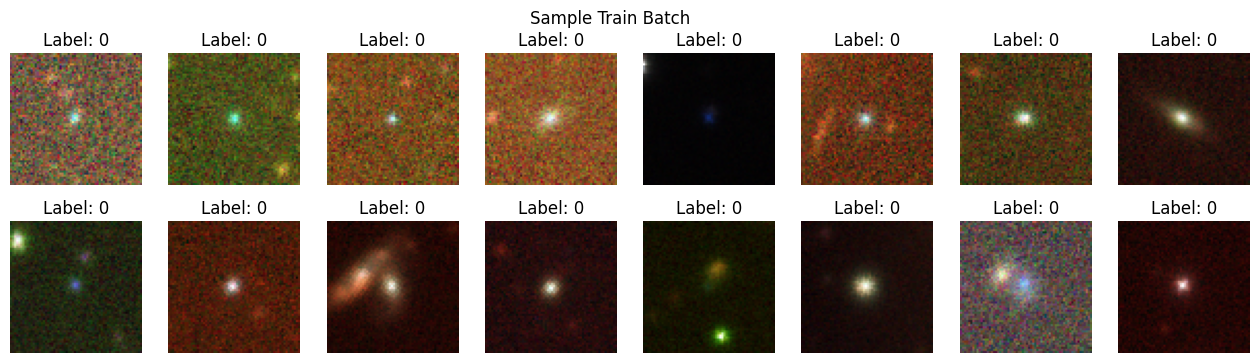

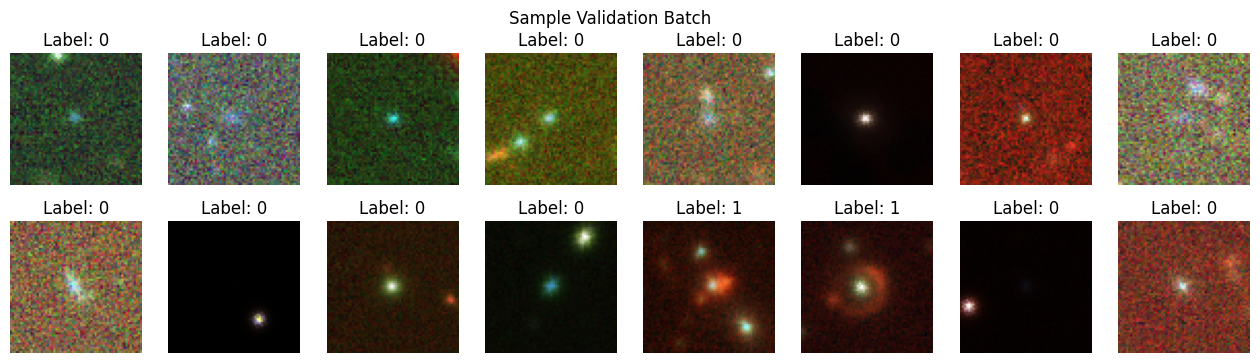

In [5]:
def show_batch(loader, title):
    imgs, labels = next(iter(loader))
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(16):
        ax = axes[i//8, i%8]
        ax.imshow(imgs[i].permute(1, 2, 0).numpy())
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

show_batch(train_loader, "Sample Train Batch")
show_batch(val_loader, "Sample Validation Batch")

# Model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
# model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s] 


# Training

In [7]:
torch.manual_seed(42)
EPOCHS = 25
LR = 0.001
criterion = nn.CrossEntropyLoss()
optimizer_class = torch.optim.Adam

optimizer = optimizer_class(model.parameters(), lr=LR)

In [8]:
def train_one_epoch(epoch):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate():
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return val_loss / total, correct / total

train_losses, val_losses, train_accs, val_accs = [], [], [], []
total_start_time = time.time() 

for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc = evaluate()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    elapsed = time.time() - start_time  # Time taken for the current epoch
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Time: {elapsed:.2f}s")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"   Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

# Calculate total time taken for training
total_elapsed = time.time() - total_start_time
total_time_minutes = total_elapsed / 60 

print(f"\nTotal training time: {total_time_minutes:.2f} minutes")

Epoch [1/25] - Time: 186.55s
   Train Loss: 0.1269 | Train Acc: 0.9490
   Val   Loss: 0.1395 | Val   Acc: 0.9319
Epoch [2/25] - Time: 55.49s
   Train Loss: 0.1022 | Train Acc: 0.9597
   Val   Loss: 0.1110 | Val   Acc: 0.9512
Epoch [3/25] - Time: 54.99s
   Train Loss: 0.1079 | Train Acc: 0.9595
   Val   Loss: 0.0890 | Val   Acc: 0.9623
Epoch [4/25] - Time: 55.20s
   Train Loss: 0.0830 | Train Acc: 0.9688
   Val   Loss: 0.0802 | Val   Acc: 0.9674
Epoch [5/25] - Time: 53.52s
   Train Loss: 0.0766 | Train Acc: 0.9708
   Val   Loss: 0.0769 | Val   Acc: 0.9709
Epoch [6/25] - Time: 55.96s
   Train Loss: 0.0824 | Train Acc: 0.9701
   Val   Loss: 0.0703 | Val   Acc: 0.9734
Epoch [7/25] - Time: 57.51s
   Train Loss: 0.0631 | Train Acc: 0.9767
   Val   Loss: 0.0673 | Val   Acc: 0.9734
Epoch [8/25] - Time: 56.91s
   Train Loss: 0.0584 | Train Acc: 0.9785
   Val   Loss: 0.0620 | Val   Acc: 0.9785
Epoch [9/25] - Time: 57.67s
   Train Loss: 0.0511 | Train Acc: 0.9806
   Val   Loss: 0.0641 | Val   Acc

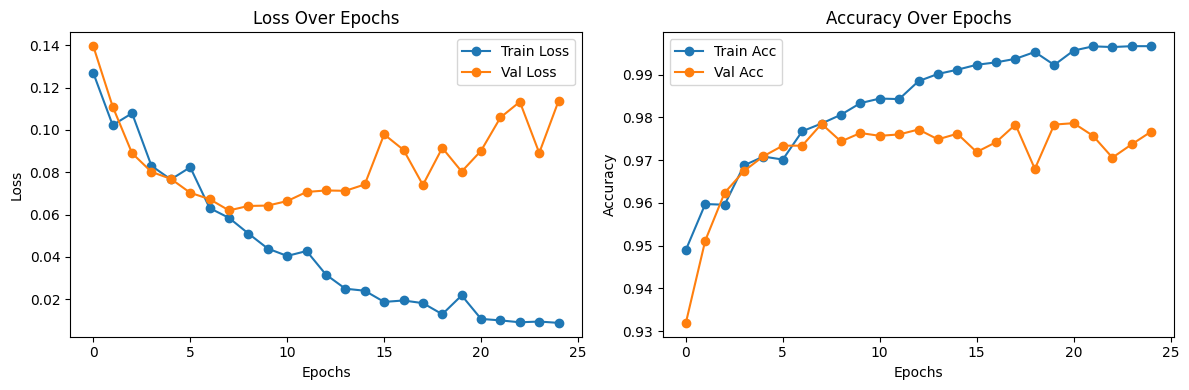

In [9]:
plt.figure(figsize=(12, 4))

# Plotting Train and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting Train and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', marker='o')
plt.plot(val_accs, label='Val Acc', marker='o')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
model_save_path = 'lens_finding_model.pth'
torch.save(model.state_dict(), model_save_path)

# Test Dataset predictions

In [11]:
test_dataset = LensDataset(
    lens_dir="/kaggle/input/lens-finding/test_lenses",
    nonlens_dir="/kaggle/input/lens-finding/test_nonlenses",
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
y_true, y_pred, probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        prob = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        probs.extend(prob)

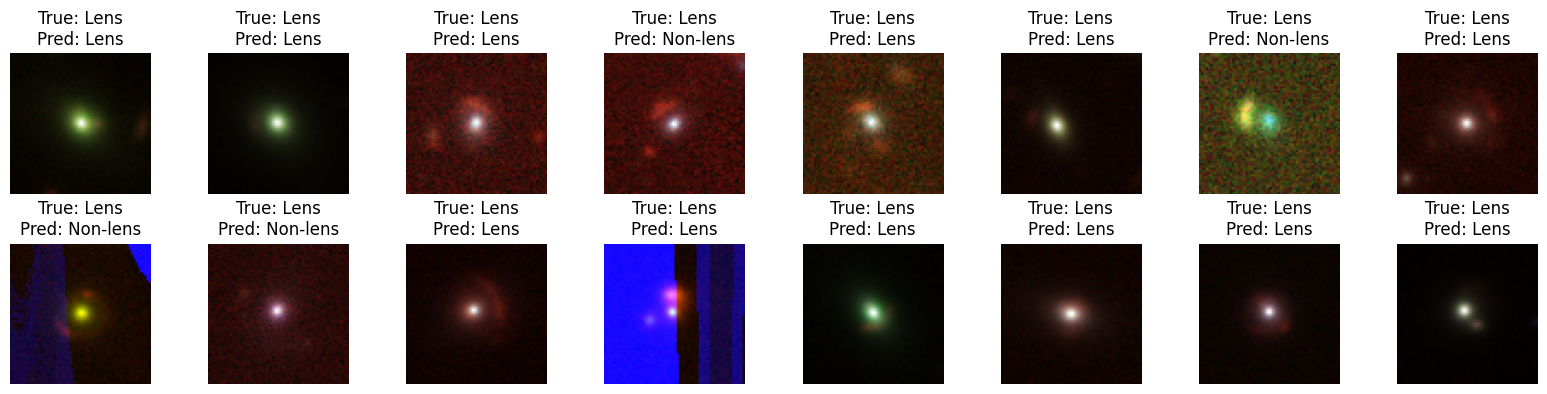

In [12]:
def show_predictions_ensure_classes(model, loader, class_names=["Non-lens", "Lens"], num_images=16):
    model.eval()
    shown = 0
    plt.figure(figsize=(16, 4))
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu()
            for i in range(imgs.size(0)):
                if shown >= num_images:
                    break
                plt.subplot(2, 8, shown+1)
                plt.imshow(imgs[i].cpu().permute(1, 2, 0).numpy())
                plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
                plt.axis("off")
                shown += 1
            if shown >= num_images:
                break
    plt.tight_layout()
    plt.show()

show_predictions_ensure_classes(model, test_loader)

# Evaluation

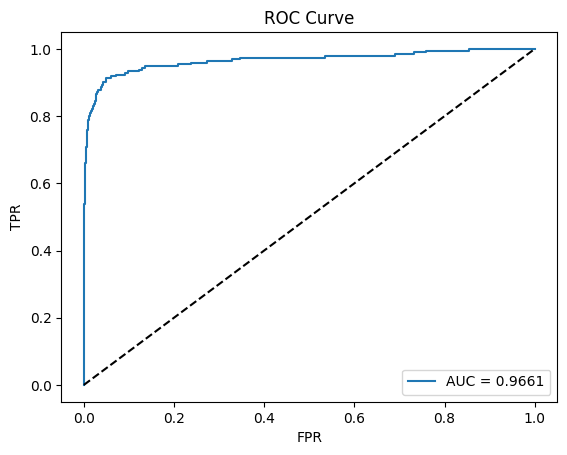

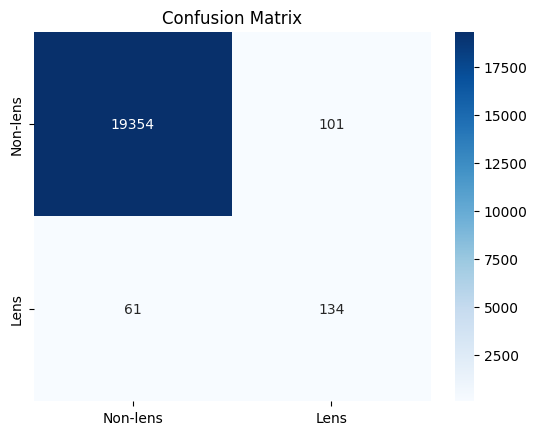

              precision    recall  f1-score   support

    Non-lens     0.9969    0.9948    0.9958     19455
        Lens     0.5702    0.6872    0.6233       195

    accuracy                         0.9918     19650
   macro avg     0.7835    0.8410    0.8095     19650
weighted avg     0.9926    0.9918    0.9921     19650



In [17]:
# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-lens", "Lens"], yticklabels=["Non-lens", "Lens"])
plt.title("Confusion Matrix")
plt.show()

# Print classification report with more decimal places
print(classification_report(y_true, y_pred, target_names=["Non-lens", "Lens"], digits=4))

In [15]:
'''
Overfitting issue
'''

'\nOverfitting issue\n'